In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
import toml
config = toml.load('../../../../configuration/input_configuration.toml')
%matplotlib inline

# os.chdir('..\..\..\..')

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
working_dir = r'../../../../outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../../inputs/db/'+config['db_name'],
        columns=['CountyName','ParcelID'])

# Usual Work Distance

In [5]:
person = pd.read_csv(r'../../../../outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'../../../../inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pwpcl', right_on='ParcelID', how='left')

In [7]:
person['wt_pwautime'] = person['pwautime']*person['psexpfac']
person['wt_pwaudist'] = person['pwaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [8]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    11.18
survey   11.79
dtype: float64

Average Distance by Work County

In [9]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,11.93,12.87
Kitsap,10.36,20.89
Pierce,10.09,11.27
Snohomish,9.94,12.74


Average for **Full-Time** Workers only

In [10]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.06
survey   13.11
dtype: float64

In [11]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.79,13.87
Kitsap,11.31,26.07
Pierce,10.80,12.79
Snohomish,10.85,14.27


Average for **Part-Time** Workers Only

In [12]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.06
survey   13.11
dtype: float64

In [13]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.79,13.87
Kitsap,11.31,26.07
Pierce,10.80,12.79
Snohomish,10.85,14.27


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Workers

<AxesSubplot:xlabel='pwaudist_bin'>

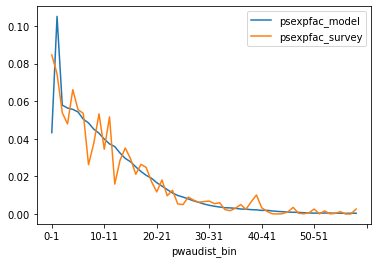

In [14]:
# Create bins
max_bin = 60
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='pwaudist_bin'>

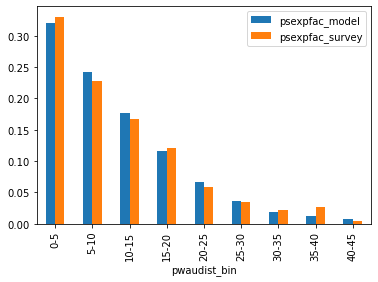

In [15]:
# Create bins
max_bin = 50
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### Percent of Workers with <1 Mile and >20 Mile Commutes

In [16]:
pd.options.display.float_format = '{:,.1%}'.format

_df_tot = person[person['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person[(person['pwaudist'] < 1) & (person['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person[(person['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,4.3%,8.4%
1,> 20 miles,15.2%,16.6%


<AxesSubplot:xlabel='Commute Range'>

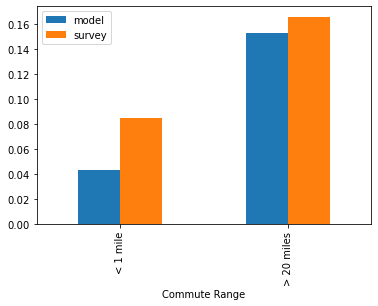

In [17]:
_df.set_index('Commute Range').plot(kind='bar',)

### Average Commute Distance by Gender

In [18]:
pd.options.display.float_format = '{:0,.2f}'.format
df = person[(person['pwaudist'] > 0) & (person['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,12.04,13.24
1,Female,10.13,9.93


<AxesSubplot:xlabel='Gender'>

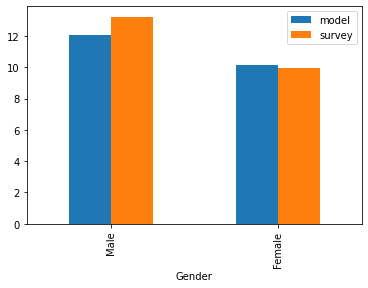

In [19]:
df.set_index('Gender').plot(kind='bar')

### Average Commute Distance by Age

In [20]:
person['age_cat'] = pd.cut(person['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person[(person['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Age Category,model,survey
0,<29,10.16,10.63
1,30-49,11.45,12.53
2,50-65,11.96,12.11
3,65+,10.48,10.84


<AxesSubplot:xlabel='Age Category'>

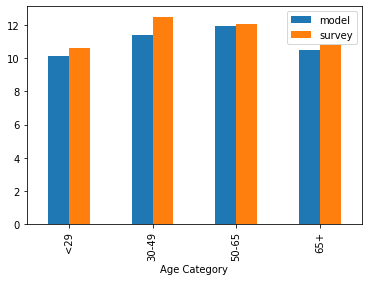

In [21]:
df.set_index('Age Category').plot(kind='bar')

## County to County Work Flows

All Workers

Model Results 

In [22]:
df = load_data(r'work_flows')
pd.options.display.float_format = '{:0,.0f}'.format
df.rename(columns={'person_county': 'Home County', 'person_work_county':'Work County'}, inplace=True)

df_model = pd.pivot_table(df[df['source'] == 'model'], index='Home County', columns='Work County', aggfunc='sum')
df_model['Total'] = df_model.sum(axis=1)
df_model.loc['Total',:] = df_model.sum(axis=0)
df_model

psexpfac                              Total
Work County      King Kitsap  Pierce Snohomish          
Home County                                             
King        1,031,021    734  30,877    35,048 1,097,680
Kitsap          9,562 22,213   1,904       125    33,804
Pierce         62,541    689 151,306       435   214,971
Snohomish      74,756     38     241   130,067   205,102
Total       1,177,880 23,674 184,328   165,675 1,551,557

Survey Results

In [23]:
df_survey = pd.pivot_table(df[df['source'] == 'survey'], index='Home County', columns='Work County', aggfunc='sum')
df_survey['Total'] = df_survey.sum(axis=1)
df_survey.loc['Total',:] = df_survey.sum(axis=0)
df_survey

psexpfac                             Total
Work County     King Kitsap Pierce Snohomish          
Home County                                           
King         762,202  2,839  5,721    20,449   791,212
Kitsap         4,455  8,941  4,074       NaN    17,470
Pierce        30,284  8,688 74,247     1,826   115,045
Snohomish     35,455    NaN  5,941    75,147   116,543
Total        832,397 20,468 89,983    97,421 1,040,270

Total Difference (Model - Survey)

In [24]:
df_model-df_survey

psexpfac                           Total
Work County     King Kitsap Pierce Snohomish        
Home County                                         
King         268,819 -2,105 25,156    14,599 306,468
Kitsap         5,107 13,272 -2,170       NaN  16,334
Pierce        32,257 -7,999 77,059    -1,391  99,926
Snohomish     39,301    NaN -5,700    54,920  88,559
Total        345,483  3,206 94,345    68,254 511,287

Percent Difference (Relative to Survey)

In [25]:
((df_model-df_survey)/df_survey).applymap(format_percent)

psexpfac                               Total
Work County     King   Kitsap   Pierce Snohomish        
Home County                                             
King          35.27%  -74.15%  439.72%    71.39%  38.73%
Kitsap       114.62%  148.43%  -53.26%      nan%  93.49%
Pierce       106.52%  -92.07%  103.79%   -76.18%  86.86%
Snohomish    110.85%     nan%  -95.94%    73.08%  75.99%
Total         41.50%   15.66%  104.85%    70.06%  49.15%